# Matching float profiles to satellite pixels
## Import Packages

In [1]:
import pandas as pd
import xarray as xr
import glob
#from pyhdf.SD import SD,SDC
import numpy as np
from datetime import *
from datetime import datetime
from FromBieito.soccom_functions import *
from FromBieito.Calc_Chl import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from matplotlib.dates import DateFormatter

### Functions

In [2]:
from PyAstronomy import pyasl

In [3]:
# calculate the vertically integrated data column inventory using the composite trapezoidal rule
# for a chosen depth range
def integrate(zi, data, depth_range):
    n_profs = len(data)
    zi_start = abs(zi - depth_range[0]).argmin() # find location of start depth
    zi_end =  abs(zi - depth_range[1]).argmin() # find location of end depth
    zi_struct = np.ones((n_profs, 1)) * zi[zi_start : zi_end] # add +1 to get the 200m value
    data = data[:, zi_start : zi_end] # add +1 to get the 200m value
    col_inv = []
    for n in range(0, len(data)):
        col_inv.append(np.trapz(data[n,:][~np.isnan(data[n,:])], zi_struct[n,:][~np.isnan(data[n,:])]))
    return col_inv

In [4]:
# calculate the vertically integrated data column inventory using the composite trapezoidal rule
# input MLD as 4th karg
def integrate_wMLD(zi, data, start_depth, MLD):
    #n_profs = len(data)
    zi_start = abs(zi - start_depth).argmin() # find index of start depth
    zi_end =  abs(zi - MLD).argmin() # find index of end depth
    zi_struct = zi[zi_start : zi_end] # add +1 to get the 200m value
    data = data[zi_start : zi_end] # add +1 to get the 200m value
    col_inv = []
    #for n in range(0, len(data)):
    col_inv.append(np.trapz(data[:][~np.isnan(data[:])], zi_struct[:][~np.isnan(data[:])]))
    return col_inv

In [5]:
def integrate_chl(data):
    # Interpolate/get data set up
    zi = np.arange(0, 2005, 5) # 5 = 400 depth intervals between 0m to 2000m
    #or zi=self.gr["depth"] #which = np.arange(0,2000+dz,dz)
    chl_int = FLOAT.gr["Chl_a"] # interpolated chl values across zi depth intervals for all profiles
    chl_int[np.where(chl_int<0)]=0 # set negative values to 0
    
    ### Using a fixed lower limit
    # Integrate chl - total chl in upper 200m
    upperlim=0
    lowerlim=200
    AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'] = np.array(integrate(zi, chl_int.T, [upperlim, lowerlim])) # integrate interpolated chl values between 0m-200m 
    
    ### Using the deepest MLD seen by the float
    # Integrate chl - total chl in upper ML - to deepest MLD seen by float
    upperlim=0
    lowerlim=np.nanmax(FLOAT.gr["mld"])
    print(FLOAT.gr["WMO_code"],"Deepest mixed layer: %1.0f m"%(lowerlim))
    AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'] = np.array(integrate(zi, chl_int.T, [upperlim, lowerlim])) # integrate interpolated chl values between 0m-200m 

    ### Using the profile specific MLD 
    ## Don't use for later analysis atm, since there is chl below MLD in some years and floats
    H2=FLOAT.gr["mld"]
    nz= len(H2)
    # using MLD calculated for each individual profile
    chl_T=chl_int.T # the interpolated chl from FLOAT.gr
    AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'] = np.full( nz, np.nan )
    for i in range(nz): #nz = length H2 (mld array) = number of profiles
        if np.isnan(H2[i]):
            AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'][i] = np.nan # in float used to write code, there were some nan for MLD because of no salinity values recorded
        else:
            lowerlim=H2[i]
            data=chl_T[i,:]
            AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'][i] = np.array(integrate_wMLD(zi, data, upperlim, lowerlim)) # integrate interpolated chl values between 0m-specificMLD

    ### The entire water column
    upperlim=0
    lowerlim=2000
    AllFloats[FLOAT.gr["WMO_code"]]['chl_intrWC'] = np.array(integrate(zi, chl_int.T, [upperlim, lowerlim])) # integrate interpolated nitrate values between 0m-200m 
    
    #return AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'],AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'],AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'],AllFloats[FLOAT.gr["WMO_code"]]['chl_intrWC']
    return AllFloats                                      

In [6]:
def meanmax_chl(data):
    # Interpolate/get data set up
    zi = np.arange(0, 2005, 5) # 5 = 400 depth intervals between 0m to 2000m
    #or zi=self.gr["depth"] #which = np.arange(0,2000+dz,dz)
    chl_int = FLOAT.gr["Chl_a"] # interpolated chl values across zi depth intervals for all profiles
    chl_int[np.where(chl_int<0)]=0 # set negative values to 0
    
    ### Using a fixed lower limit
    H = 200 
    jh = np.where( FLOAT.gr["depth"]>= H)[0][0] # gets the depth index for the maxmum mixed layer
    profs=FLOAT.gr["Chl_a"].shape[1] #len(FLOAT.gr["Chl_a"].T)
    
    AllFloats[FLOAT.gr["WMO_code"]]['dMean_Chl']=[]
    AllFloats[FLOAT.gr["WMO_code"]]['dMax_Chl']=[]
    AllFloats[FLOAT.gr["WMO_code"]]['surf_Chl']=[]
    for nix in range(0,profs):
        #depth mean chl
        meanT=np.nanmean(chl_int[:jh,nix])
        maxT = np.nanmax(chl_int[:jh,nix])
        df = pd.DataFrame(chl_int[:jh,nix])
        idx=df.first_valid_index()
        firstT = df.loc[idx] if idx is not None else None
        AllFloats[FLOAT.gr["WMO_code"]]['dMean_Chl'] = np.append(AllFloats[FLOAT.gr["WMO_code"]]['dMean_Chl'],meanT)
        AllFloats[FLOAT.gr["WMO_code"]]['dMax_Chl'] = np.append(AllFloats[FLOAT.gr["WMO_code"]]['dMax_Chl'],maxT)
        AllFloats[FLOAT.gr["WMO_code"]]['surf_Chl'] = np.append(AllFloats[FLOAT.gr["WMO_code"]]['surf_Chl'],firstT)
                    
    return AllFloats                                      

In [7]:
def chl_underornoice(data,yix):
    H2=FLOAT.gr["mld"]
    nz= len(H2)
    ## How much of the annual chl was present under ice?
    AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno']=np.full(nz, np.nan)
    temp_IP=FLOAT.raw["Interpolated_Position"]
    AllFloats[FLOAT.gr["WMO_code"]]['InterPos']=np.int_(np.array(temp_IP.split()))
    AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno_IP']=np.full(nz, np.nan)
    for i in range(nz):
        test= np.isnan(FLOAT.gr["Temperature"][8,i]) #np.isnan(FLOAT.gr["Temperature"][0,i]) & np.isnan(FLOAT.gr["Temperature"][1,i]) & np.isnan(FLOAT.gr["Temperature"][2,i]) & np.isnan(FLOAT.gr["Temperature"][3,i]) & np.isnan(FLOAT.gr["Temperature"][4,i]) & #& np.isnan(FLOAT.gr["Temperature"][6,i]) & np.isnan(FLOAT.gr["Temperature"][7,i])
        temp_thres=np.nanmedian(FLOAT.gr["Temperature"][20:50,i])<(-1.78)
        if test.all() | temp_thres.all():
            AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]=1
        else:
            AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]=0
            
        test2=i==AllFloats[FLOAT.gr["WMO_code"]]['InterPos']
        if test2.any() & temp_thres.all():
            AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno_IP'][i]=1
        else:
            AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno_IP'][i]=0
    #### Over the whole float timeseries
    ui=np.where(np.isnan(FLOAT.gr["Chl_a"][0,:]) & np.isnan(FLOAT.gr["Chl_a"][1,:]) & np.isnan(FLOAT.gr["Chl_a"][2,:]) & np.isnan(FLOAT.gr["Chl_a"][3,:])) #& np.isnan(FLOAT.gr["Chl_a"][4,i]) #& np.isnan(FLOAT.gr["Chl_a"][5,i])
    ui_tot=np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'][ui])
    nui=np.where(np.isfinite(FLOAT.gr["Chl_a"][0,:]) & np.isnan(FLOAT.gr["Chl_a"][1,:]) & np.isnan(FLOAT.gr["Chl_a"][2,:]) & np.isnan(FLOAT.gr["Chl_a"][3,:])) #& np.isnan(FLOAT.gr["Chl_a"][4,i]) #& np.isnan(FLOAT.gr["Chl_a"][5,i])
    nui_tot=np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'][nui])
    #print(np.nansum(chl_intr_dMLD))
    #print('approx % of chl under ice during float timeseries:', round(ui_tot/nui_tot*100,2),'%')
    
    #### get index for profiles that are in austral year, under ice and ice free
    AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]=[]
    AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]=[]
    AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]=[]
    for i in range(len(FLOAT.gr["date_dt"])):
        decy = pyasl.decimalYear(FLOAT.gr["date_dt"][i]) #might be more efficient to make decy an np.int_ here so all the logical queries can be called at once?...
        smol=decy>=(yix-0.5)
        tol=decy<(yix+0.5)
        underice=AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]>0
        icefree=AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]==0
        if smol==tol:
            AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"],np.int_(i))#
        if smol==tol==underice:
            AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"],np.int_(i))
        if smol==tol==icefree:
            AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"],np.int_(i))
    AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"])
    AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"])
    AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"])
    # exlude years with <34 profiles from next lot of calculations?
    ### Calculate how much Chl is present at specific times - whole year, under ice, when there's no ice
    #could add if rule: if len(AllFloats['5904472'][endyear]["aust_ix"])<34: continue... or [] =np.nan
    if len(AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"])>34: 
        #### Total in austral year
        AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]=np.round(np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'][AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]]),6)
        #### Total under ice
        AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_underice_chl"]=np.round(np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'][AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]]),6)
        #### Total when ice-free
        AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_icefree_chl"]=np.round(np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'][AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]]),6)
        #### proportion under ice for austral year
        AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_underice"]=AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_underice_chl"]/AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]
        AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_icefree"]=AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_icefree_chl"]/AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]
        #### Mean [Chl] in WC
        #AllFloats['5904472'][yix]["Mean_aus_chl"]=np.round(np.nanmean(chl_intrWC[AllFloats['5904472'][yix]["aust_ix"]]),6)
    else:
        #### Total in austral year
        AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]=np.nan
        #### Total under ice
        AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_underice_chl"]=np.nan
        #### Total when ice-free
        AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_icefree_chl"]=np.nan
        #### proportion under ice for austral year
        AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_underice"]=np.nan
        AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_icefree"]=np.nan
        #### Mean [Chl] in WC
        #AllFloats['5904472'][yix]["Mean_aus_chl"]=np.nan
    #for yix in range(startyear,endyear+1,1):
    print(yix,"under ice",np.round(AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_underice"],3))
    #for yix in range(startyear,endyear+1,1):
    #    print(yix,"ice free",np.round(AllFloats['5904472'][yix]["Prop_icefree"],3))
        
    #return AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'],AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"],AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"],AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_underice_chl"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_icefree_chl"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_underice"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_icefree"]
    return AllFloats

In [8]:
def nosat_chl(data,yix):
    ## What is happening to the chl when the satellite isn't seeing the ice-free waters (from ~mid March)?
    Mar2214=datetime.datetime(2014,3,22)
    decmar14=pyasl.decimalYear(Mar2214)
    Mar3015=datetime.datetime(2015,3,30)
    decmar15=pyasl.decimalYear(Mar3015)
    Mar2116=datetime.datetime(2016,3,21)
    decmar16=pyasl.decimalYear(Mar2116)
    Mar2217=datetime.datetime(2017,3,22)
    decmar17=pyasl.decimalYear(Mar2217)
    Mar1418=datetime.datetime(2018,3,14)
    decmar18=pyasl.decimalYear(Mar1418)
    Mar1419=datetime.datetime(2019,3,14)
    decmar19=pyasl.decimalYear(Mar1419)
    Mar2120=datetime.datetime(2020,3,21)
    decmar20=pyasl.decimalYear(Mar2120)
    Mar1421=datetime.datetime(2021,3,14)
    decmar21=pyasl.decimalYear(Mar1421)
    

    AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]=[]
    for i in range(len(FLOAT.gr["date_dt"])):
        decy = pyasl.decimalYear(FLOAT.gr["date_dt"][i])
        smol=decy>=(yix-0.5)
        tol=decy<(yix+0.5)
        icefree=AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]==0
        if yix==2014:
            mar=decy>=decmar14
        elif yix==2015:
            mar=decy>=decmar15
        elif yix==2016:
            mar=decy>decmar16
        elif yix==2017:
            mar=decy>decmar17
        elif yix==2018:
            mar=decy>decmar18
        elif yix==2019:
            mar=decy>decmar19
        elif yix==2020:
            mar=decy>decmar20
        elif yix==2021:
            mar=decy>decmar21
        if smol==tol==mar: #==icefree
            AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"],i)
        AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"])
    
    #could add if rule: if len(AllFloats['5904472'][endyear]["aust_ix"])<34: continue... or [] =np.nan
    #### Total chl when satellite field of view reduces during March, but before ice returns
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_nosat_chl"]=np.round(np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'][AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]]),6)
    #### proportion under ice for austral year
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_nosat"]=AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_nosat_chl"]/AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]
    print(yix,"no satellite coverage",np.round(AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_nosat"],3))
    return AllFloats

## Load in satellite data

In [9]:
rootdir = '../data/interim/'
satfiles = sorted(glob.glob(rootdir+"/chl*.nc")) #nans
print(satfiles)

chl_satellite=xr.open_dataset(satfiles[0])
#display(chl_satellite)

['../data/interim\\chl_2014onwards_nans.nc']


### Time is in matlab datenum 
= Need to convert to datetime

* Pos ask about how to put the values into the xarray dataset, but for now, is made as a separate variable (means a few extra lines later on)

In [10]:
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    return datetime.datetime.fromordinal(int(datenum)) \
           + timedelta(days=days) \
           - timedelta(days=366)

In [11]:
nz= len(chl_satellite.date.values)
print(chl_satellite.date.values[0])
datezz=[]
for i in range(0,nz):
    datezz=np.append(datezz,datenum_to_datetime(chl_satellite.date.values[i]))
print(datezz[0])

735603.999994213
2014-01-04 23:59:59.500003


In [12]:
#test isel command
#display(chl_satellite['npp'].isel(date=6,lat=500,lon=800))
chl_satellite['chl'].isel(date=6,lat=500,lon=800).values

array(0.22004464)

## Load in float data
One at a time for the moment

In [13]:
file_folder = "../data/raw/WGfloats/" # specify directory relative to location of notebook #SOCCOM_HiResQC_LIAR_21Dec2021_netcdf # WGfloats
###    For single float: 
#float_number = "5904471" #7900918 #9094/5904471 #5904397
#files = sorted(glob.glob(file_folder+"/*"+float_number+"*.nc"))
#print(files)
#uses the function that reads and grids the data
#FLOAT = grids_one_buoy(files[0],display_info = False, DO_ml_crit = 2.5, clear_short = True)
#print("This float is WMO code: %s"%(FLOAT.gr["WMO_code"]))

###    For all floats:
files = sorted(glob.glob(file_folder+"/*.nc"))
print(files)
files1=files[0:2]
print(files1)

['../data/raw/WGfloats\\5904397_HRQC.nc', '../data/raw/WGfloats\\5904467_HRQC.nc', '../data/raw/WGfloats\\5904468_HRQC.nc', '../data/raw/WGfloats\\5904471_HRQC.nc', '../data/raw/WGfloats\\5904472_HRQC.nc', '../data/raw/WGfloats\\5905991_HRQC.nc', '../data/raw/WGfloats\\5905992_HRQC.nc', '../data/raw/WGfloats\\5905993_HRQC.nc', '../data/raw/WGfloats\\5905994_HRQC.nc', '../data/raw/WGfloats\\5905995_HRQC.nc', '../data/raw/WGfloats\\5906033_HRQC.nc', '../data/raw/WGfloats\\5906034_HRQC.nc']
['../data/raw/WGfloats\\5904397_HRQC.nc', '../data/raw/WGfloats\\5904467_HRQC.nc']


### Calculate depth integrated chl to compare to satellite NPP

In [14]:
import warnings
warnings.filterwarnings('ignore')
# because next cell has warnings for each iteration -- ask someone about them in future

In [16]:
# READ FLOAT FUNCTION INTO A VARIABLE TO KEEP ALL FLOAT RAW DATA HANDY:
AllRaw = {}
float_ID=[]
for f in files: #[files1]: #files: #[files[5]]:
    FLOAT = grids_one_buoy(f,display_info = False, DO_ml_crit = 2.5, clear_short = True,dz=1) #load in float data 
    float_ID=np.append(float_ID,FLOAT.gr["WMO_code"])
    AllRaw[FLOAT.gr["WMO_code"]] = {}
    AllRaw[FLOAT.gr["WMO_code"]]['FLOAT']=FLOAT
    print(float_ID)
#print(AllRaw['5904397']['FLOAT'].gr["WMO_code"])         

['5904397']
['5904397' '5904467']
['5904397' '5904467' '5904468']
['5904397' '5904467' '5904468' '5904471']
['5904397' '5904467' '5904468' '5904471' '5904472']
['5904397' '5904467' '5904468' '5904471' '5904472' '5905991']
['5904397' '5904467' '5904468' '5904471' '5904472' '5905991' '5905992']
['5904397' '5904467' '5904468' '5904471' '5904472' '5905991' '5905992'
 '5905993']
['5904397' '5904467' '5904468' '5904471' '5904472' '5905991' '5905992'
 '5905993' '5905994']
['5904397' '5904467' '5904468' '5904471' '5904472' '5905991' '5905992'
 '5905993' '5905994' '5905995']
['5904397' '5904467' '5904468' '5904471' '5904472' '5905991' '5905992'
 '5905993' '5905994' '5905995' '5906033']
['5904397' '5904467' '5904468' '5904471' '5904472' '5905991' '5905992'
 '5905993' '5905994' '5905995' '5906033' '5906034']


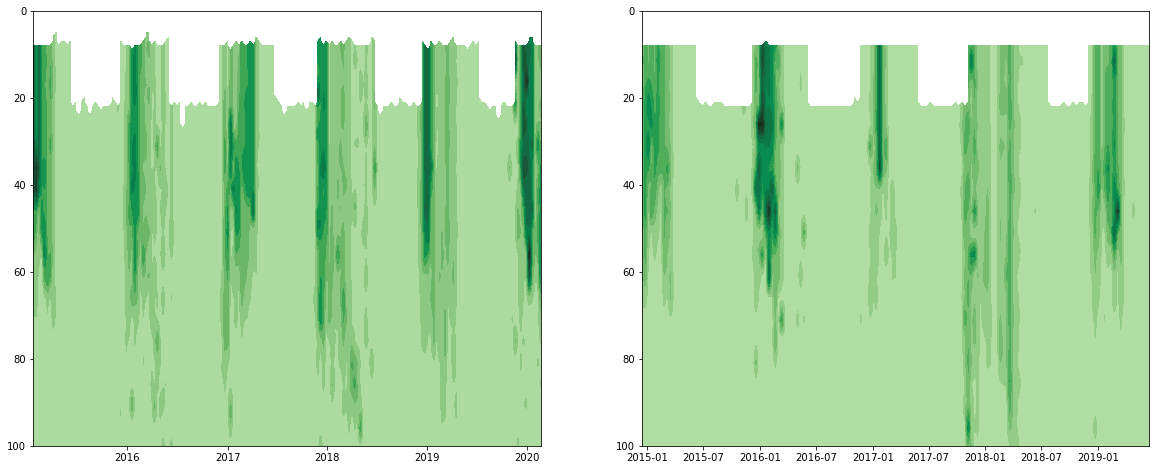

In [393]:
plt.figure(figsize=(20, 8))
plt.subplots_adjust(hspace=0.5)
#plt.suptitle("Float Integrated Chl vs Satellite [Chl] at closest pixel and time per profile", fontsize=18, y=0.95)

for n,f in enumerate(['5904397','5904467']): #[files1]: #files: #[files[5]]:
    # loop through the length of tickers and keep track of index
    # add a new subplot iteratively
    ax = plt.subplot(1,2,n+1)#(1,1,n+1)#(3, 4, n + 1)
    #plt.title(FLOAT.gr["WMO_code"])
    cfT=ax.contourf(AllRaw[f]['FLOAT'].gr["date_dt"],All[f]['FLOAT'].gr["depth"][0:320],All[f]['FLOAT'].gr["Chl_a"][0:320],10, cmap = cmocean.cm.algae)
    ax.set_ylim(0,100)
    plt.gca().invert_yaxis()
    cb = fig.colorbar(cfT)

In [18]:
#make structure for floats 
AllFloats = {}
for fi,f in enumerate(files): #[files1]: #files: #[files[5]]:
    #FLOAT = grids_one_buoy(f,display_info = False, DO_ml_crit = 2.5, clear_short = True,dz=1) #load in float data 
    float_=float_ID[fi]
    FLOAT=AllRaw[float_]['FLOAT']
    AllFloats[FLOAT.gr["WMO_code"]] = {} # blank class for float
    AllFloats[FLOAT.gr["WMO_code"]]['dates_dt']=FLOAT.gr["date_dt"]
    AllFloats[FLOAT.gr["WMO_code"]]['lon']=FLOAT.gr["Lon"]
    AllFloats[FLOAT.gr["WMO_code"]]['lat']=FLOAT.gr["Lat"]
    #print(float_ID)
    #upperlim=0
    #lowerlim=np.nanmax(FLOAT.gr["mld"])
    #print(FLOAT.gr["WMO_code"],"Deepest mixed layer: %1.0f m"%(lowerlim))
    
    #AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'],AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'],AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'],AllFloats[FLOAT.gr["WMO_code"]]['chl_intrWC']=integrate_chl(FLOAT)
    AllFloats=integrate_chl(FLOAT)
    AllFloats=meanmax_chl(FLOAT)
    
    ##### Get year range
    startyear=FLOAT.gr["date_dt"][0].year
    endyear=FLOAT.gr["date_dt"][-1].year
    #print(startyear, '-', endyear)
    #yearrange=range(startyear,endyear+1)
    #print(yearrange)
    nosat_temp=[] # getting 0/1 for no sat coverage at the end of the year for plotting later
    
    for yix in np.arange(startyear,endyear+1):
        #print(yix)
        AllFloats[FLOAT.gr["WMO_code"]][yix] ={}
        AllFloats=chl_underornoice(FLOAT,yix)
        AllFloats=nosat_chl(FLOAT,yix)
        
        nosat_temp=(np.append(nosat_temp,AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]))
    
    AllFloats[FLOAT.gr["WMO_code"]]['no_sat_yesno']=np.full(len(AllFloats[FLOAT.gr["WMO_code"]]['dates_dt']), np.nan) # getting 0/1 for no sat coverage at the end of the year for plotting later
    for i in range(0,len(AllFloats[FLOAT.gr["WMO_code"]]['dates_dt'])): # getting 0/1 for no sat coverage at the end of the year for plotting later
        if (len(list(filter (lambda x : x == i, nosat_temp))) > 0):
            #print(i)
            AllFloats[FLOAT.gr["WMO_code"]]['no_sat_yesno'][i]=1
        else:
            AllFloats[FLOAT.gr["WMO_code"]]['no_sat_yesno'][i]=0
    
    ##### Get satellite values for each profile for each float
    fz=len(FLOAT.gr["date_dt"])
    ## Select satellite pixel and get NPP value
    AllFloats[FLOAT.gr["WMO_code"]]['Chl_atprofiles']=np.full(fz,np.nan)
    AllFloats[FLOAT.gr["WMO_code"]]['satnan']=np.full(fz,np.nan)
    AllFloats[FLOAT.gr["WMO_code"]]['sat_date']=[]
    for fix in range(0,fz):
        #print(FLOAT.gr["date_dt"][fix])
        #print(FLOAT.gr["Lat"][0])
        #print(FLOAT.gr["Lon"][0])
        float_date = FLOAT.gr["date_dt"][fix]
        # get all differences with date as values 
        cloz_dict = { 
          abs(float_date.timestamp() - date.timestamp()) : date 
          for date in datezz}
        # extracting minimum key using min()
        AllFloats[FLOAT.gr["WMO_code"]]['sat_date'] = np.append(AllFloats[FLOAT.gr["WMO_code"]]['sat_date'],cloz_dict[min(cloz_dict.keys())])
        #print("Nearest date from float date : " + str(sat_date))
        #date_ix=[]
        date_ix=np.where(datezz==AllFloats[FLOAT.gr["WMO_code"]]['sat_date'][fix])
        date_sel=chl_satellite['date'][date_ix]
        
        #AllFloats[FLOAT.gr["WMO_code"]]['Chl_atprofiles'][fix]=chl_satellite['chl'].sel(date=date_sel,lat=FLOAT.gr["Lat"][0],lon=FLOAT.gr["Lon"][0],method='nearest').values
        AllFloats[FLOAT.gr["WMO_code"]]['Chl_atprofiles'][fix]=chl_satellite['chl'].sel(date=date_sel,lat=FLOAT.gr["Lat"][fix],lon=FLOAT.gr["Lon"][fix],method='nearest').values
        #AllFloats[FLOAT.gr["WMO_code"]]['Chl_atprofiles'][fix]=chl_satellite['chl'].sel(date=date_sel,lat=-50,lon=25,method='nearest').values # just choosing a randon single location to check code
        
    AllFloats[FLOAT.gr["WMO_code"]]['satnan']=np.zeros_like(AllFloats[FLOAT.gr["WMO_code"]]['Chl_atprofiles']) #1 where there is nan for satellite NPP value
    AllFloats[FLOAT.gr["WMO_code"]]['satnan'][np.isnan(AllFloats[FLOAT.gr["WMO_code"]]['Chl_atprofiles'])]=1
    
    #AllFloats[FLOAT.gr["WMO_code"]]['Chl_atprofiles'][np.where(AllFloats[FLOAT.gr["WMO_code"]]['Chl_atprofiles']<0)]=np.nan
    #display(AllFloats[FLOAT.gr["WMO_code"]]['Chl_atprofiles'])

5904397 Deepest mixed layer: 142 m
2015 under ice nan
2015 no satellite coverage nan
2016 under ice 0.081
2016 no satellite coverage 0.217
2017 under ice 0.053
2017 no satellite coverage 0.32
2018 under ice 0.057
2018 no satellite coverage 0.25
2019 under ice 0.085
2019 no satellite coverage 0.26
2020 under ice nan
2020 no satellite coverage nan
5904467 Deepest mixed layer: 141 m
2014 under ice nan
2014 no satellite coverage nan
2015 under ice nan
2015 no satellite coverage nan
2016 under ice 0.051
2016 no satellite coverage 0.091
2017 under ice 0.062
2017 no satellite coverage 0.119
2018 under ice 0.096
2018 no satellite coverage 0.302
2019 under ice nan
2019 no satellite coverage nan
5904468 Deepest mixed layer: 178 m
2015 under ice nan
2015 no satellite coverage nan
2016 under ice 0.021
2016 no satellite coverage 0.065
2017 under ice 0.026
2017 no satellite coverage 0.15
2018 under ice 0.035
2018 no satellite coverage 0.287
2019 under ice 0.013
2019 no satellite coverage 0.146
2020 

(92,)
(2001,)
(2001, 92)


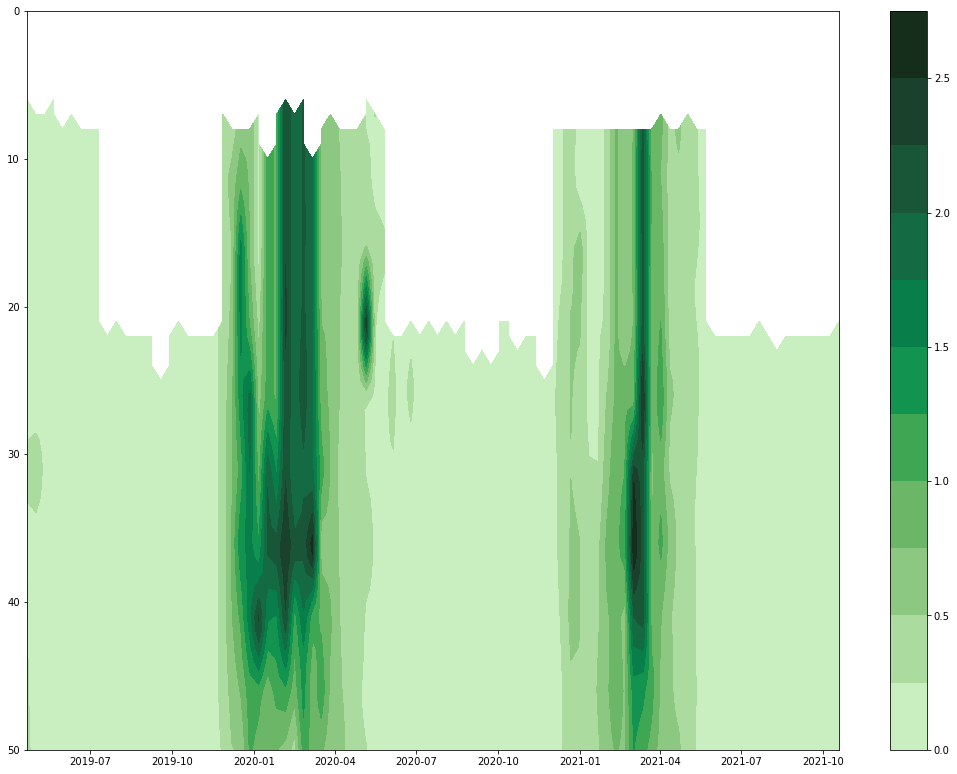

In [17]:
fig = plt.figure(figsize = (30,38))
ax0 = fig.add_axes([0.57,0.35,0.47,0.27])
#num=np.arange(1,234,1)
print(FLOAT.gr["date"].shape)
print(FLOAT.gr["depth"].shape)
print(FLOAT.gr["Chl_a"].shape)
cfT=ax0.contourf(FLOAT.gr["date_dt"],FLOAT.gr["depth"][0:320],FLOAT.gr["Chl_a"][0:320],10, cmap = cmocean.cm.algae)
ax0.set_ylim(0,50)
plt.gca().invert_yaxis()
cb = fig.colorbar(cfT)

#ax0.plot(FLOAT.gr["date_dt"],np.full(FLOAT.gr["date"].size,5)) #i=1
#ax0.plot(FLOAT.gr["date_dt"],np.full(FLOAT.gr["date"].size,10)) #i=2
#ax0.plot(FLOAT.gr["date_dt"],np.full(FLOAT.gr["date"].size,15)) #i=3



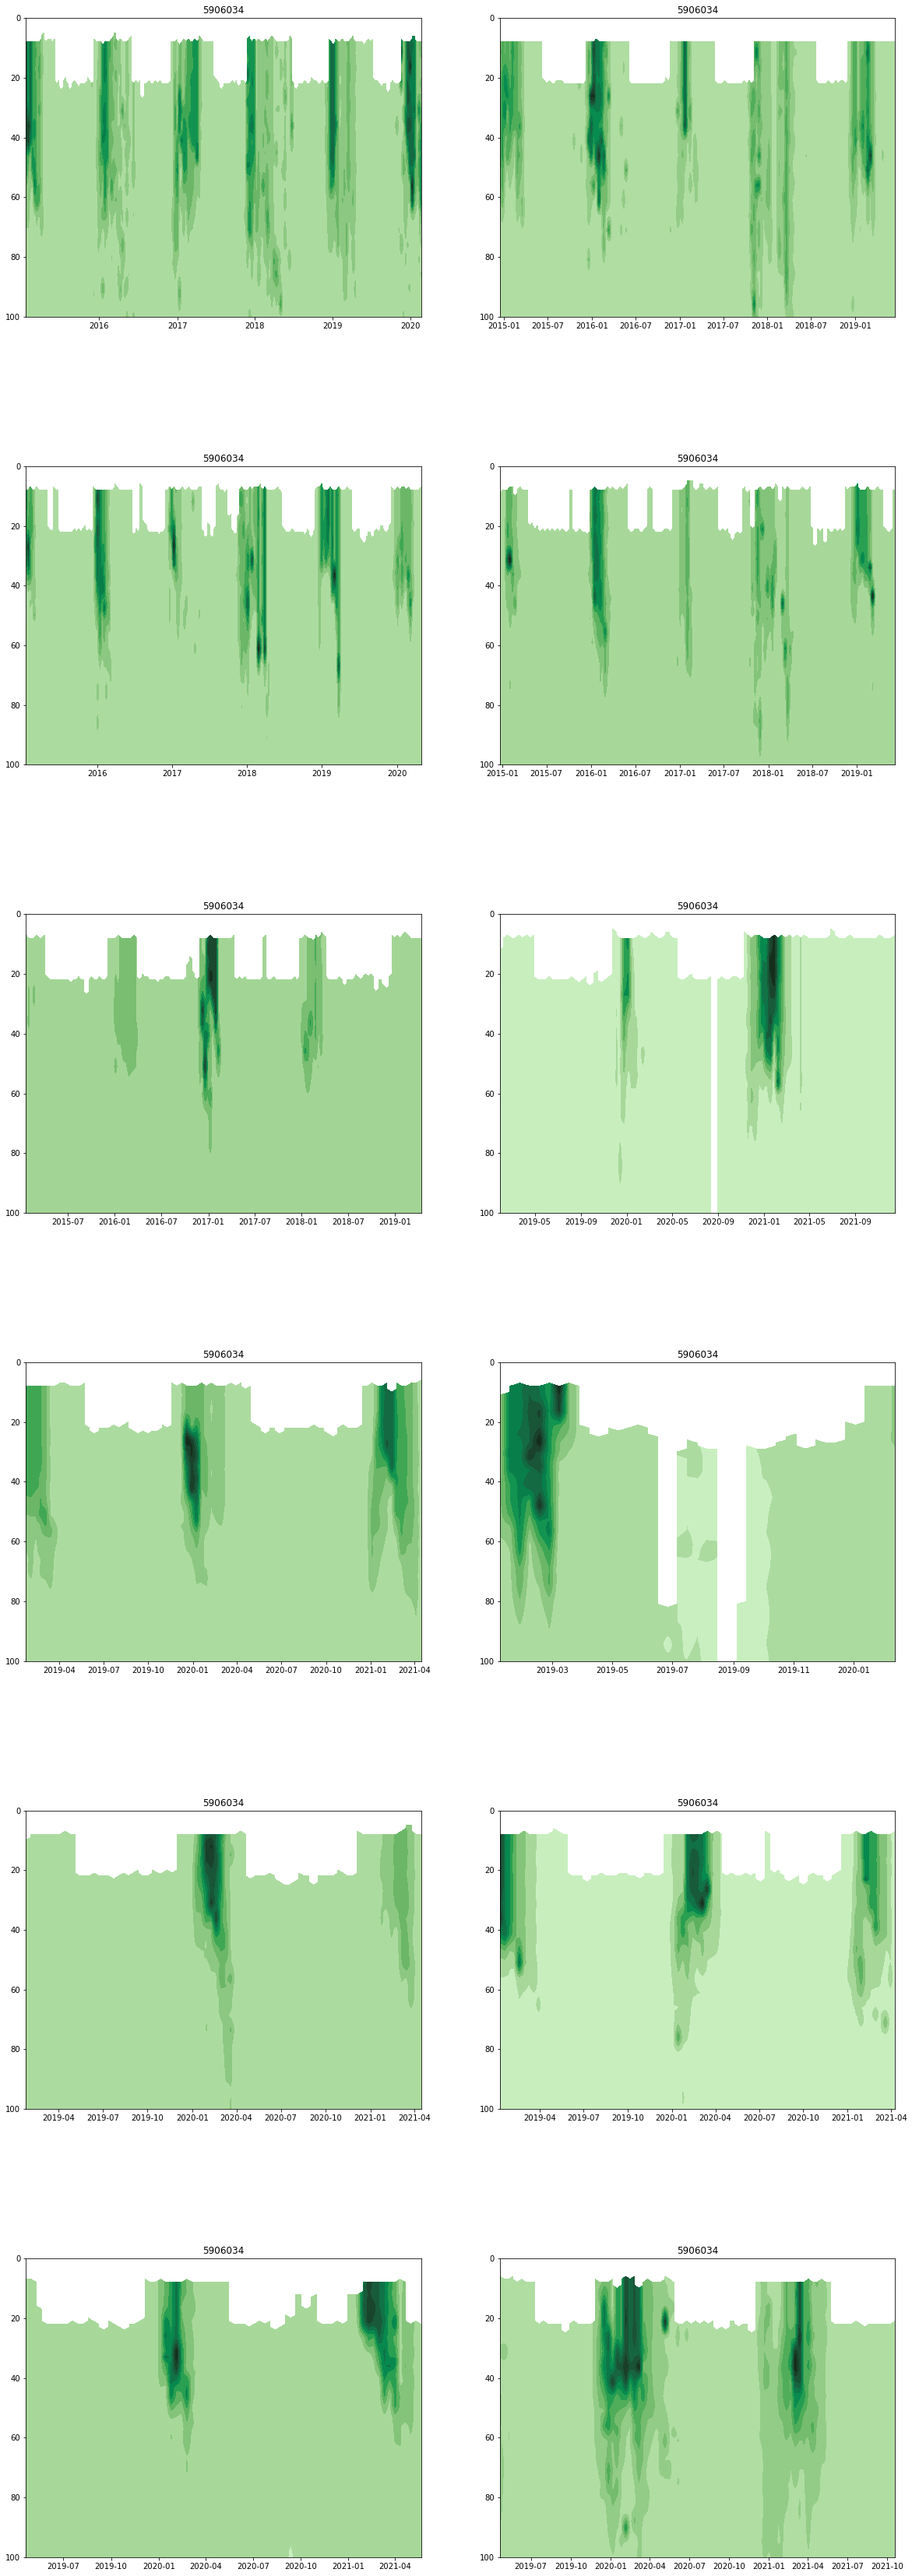

In [74]:
plt.figure(figsize=(20, 60))
plt.subplots_adjust(hspace=0.5)
#plt.suptitle("Float Integrated Chl vs Satellite [Chl] at closest pixel and time per profile", fontsize=18, y=0.95)

for n,f in enumerate(files): #[files1]: #files: #[files[5]]:
    FLOAT = grids_one_buoy(f,display_info = False, DO_ml_crit = 2.5, clear_short = True,dz=1) #load in float data 
    # loop through the length of tickers and keep track of index
    # add a new subplot iteratively
    ax = plt.subplot(6,2,n+1)#(1,1,n+1)#(3, 4, n + 1)
    plt.title(FLOAT.gr["WMO_code"])
    cfT=ax.contourf(FLOAT.gr["date_dt"],FLOAT.gr["depth"][0:320],FLOAT.gr["Chl_a"][0:320],10, cmap = cmocean.cm.algae)
    ax.set_ylim(0,100)
    plt.gca().invert_yaxis()
    cb = fig.colorbar(cfT)


In [70]:
len(files1)

4

Text(0, 0.5, '$\\mathregular {Depth Integrated Chlorophyll (mg/m^2)}$')

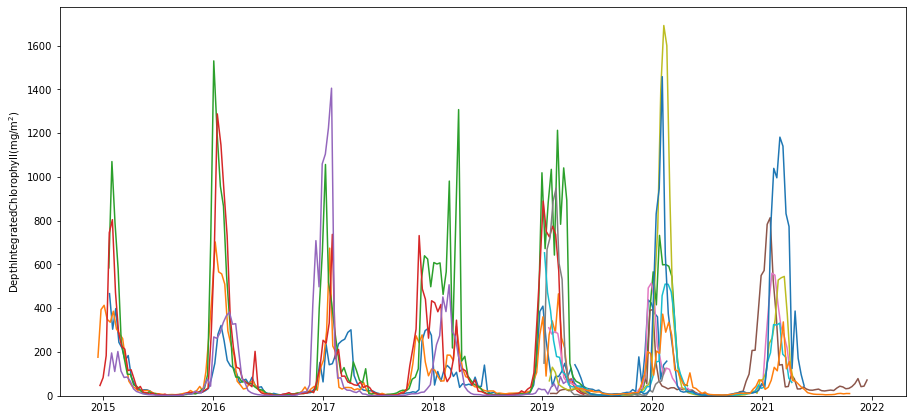

In [18]:
#Plot
#fig = plt.subplots(figsize = (20, 8))
#plt.plot(AllFloats[FLOAT.gr["WMO_code"]]['sat_date'],AllFloats[FLOAT.gr["WMO_code"]]['Chl_atprofiles'], c='black')
#plt.ylabel('NPP (mg/m2/d1)')
#plt.xlabel('Date')

fig = plt.figure(figsize = (25,20))
ax0 = fig.add_axes([0.07,0.65,0.47,0.27])
for f_ix in range(0,len(float_ID)):
    ID=float_ID[f_ix]
    chl=AllFloats[ID]['chl_intr200']
    date=AllFloats[ID]['dates_dt']
    
    ax0.plot(date,chl)
ax0.set_ylim(0)
ax0.set_ylabel('$\mathregular {Depth Integrated Chlorophyll (mg/m^2)}$')
    
#ax1=ax0.twinx()
#ax1.plot(sat_date,Chl_atprofiles, c='black',linewidth=3)
#ax1.set_ylabel('$\mathregular {Daily NPP Rates (mgC/m^2/d^1)}$')

#underice4,=ax0.plot(FLOAT.gr["date_dt"],(AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno']*(np.nanmax(chl))),c='lightblue',ls=':',lw=3)
#nosat__,=ax0.plot(FLOAT.gr["date_dt"],(AllFloats[FLOAT.gr["WMO_code"]]['no_sat_yesno']*(np.nanmax(chl))),c='orange',ls=':',lw=3)

In [19]:
Chl_WG=pd.read_csv('../data/processed/chl_data.csv',header=None).values
print(Chl_WG.shape)
#DailyNPP[np.isnan(DailyNPP)]=0
Chl_WG_cut1=Chl_WG[0:319]
Chl_WG_cut2=Chl_WG[321:]
Chl_WG_cut=np.append(Chl_WG_cut1,Chl_WG_cut2)
print(Chl_WG_cut.shape)

Chl_dates=pd.read_csv('../data/processed/chl_datenum.csv',header=None).values
#Chl_dates=np.array(Chl_dates)
print(Chl_dates.shape)
#display(DailyNPP_dates)
#print(range(len(DailyNPP_dates)))
print(datezz.shape)
print(datezz[0])

(368, 1)
(366,)
(368, 1)
(366,)
2014-01-04 23:59:59.500003


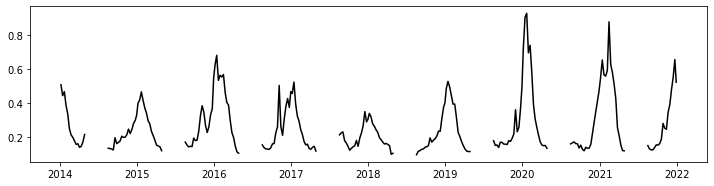

In [20]:
fig = plt.figure(figsize = (20,8))
ax0 = fig.add_axes([0.07,0.35,0.47,0.27])
#ax0.plot(Chl_dates,Chl_WG[:,0], c='black')
ax0.plot(datezz,Chl_WG_cut[:], c='black')

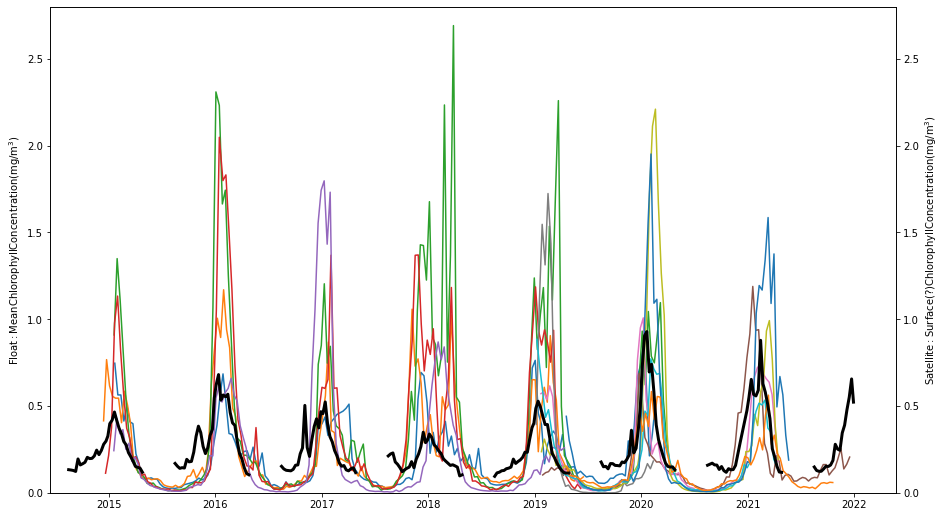

In [21]:
fig = plt.figure(figsize = (25,25))
ax0 = fig.add_axes([0.07,0.65,0.47,0.27])
for f_ix in range(0,len(float_ID)):
    ID=float_ID[f_ix]
    chl=AllFloats[ID]['dMean_Chl'] #chl_intr200 #surf_Chl #dMean_Chl
    date=AllFloats[ID]['dates_dt']
    ax0.plot(date,chl)
ax0.set_ylim(0)
ax0.set_ylim([0,2.8])
#ax0.set_ylim([0,12])

#ax0.set_ylabel('$\mathregular {Depth Integrated Chlorophyll (mg/m^2)}$')
ax0.set_ylabel('$\mathregular {Float: Mean Chlorophyll Concentration (mg/m^3)}$')

#ax0.plot([2014,2022],[0,0],c='grey', linestyle='dashed')

ax1=ax0.twinx()
ax1.plot(datezz,Chl_WG_cut[:], c='black',linewidth=3)
ax1.set_ylim([0,2.8])
ax1.set_xlim(left=datezz[20])
ax1.set_ylabel('$\mathregular {Satellite: Surface(?) Chlorophyll Concentration (mg/m^3)}$')

plt.rcParams.update({'font.size': 6})
plt.rc('font', size=15)

plt.savefig("FloatMean_SatelliteSurf_ChlConc.pdf",
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = True,
            facecolor ="w",
            edgecolor ='w',
            orientation ='landscape')


In [22]:
print(float_ID.size)

12


In [23]:
for n, float_ in enumerate(float_ID):
    print(np.nanmax(AllFloats[float_]['Chl_atprofiles']))

1.0360363721847534
0.7938647866249084
1.96078360080719
2.473612070083618
3.8278374671936035
1.8467050790786743
1.3927991390228271
2.500295877456665
48.83648681640625
1.0624287128448486
2.9762516021728516
0.4453566074371338


In [24]:
AllFloats['5905991']['underice_yesno']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

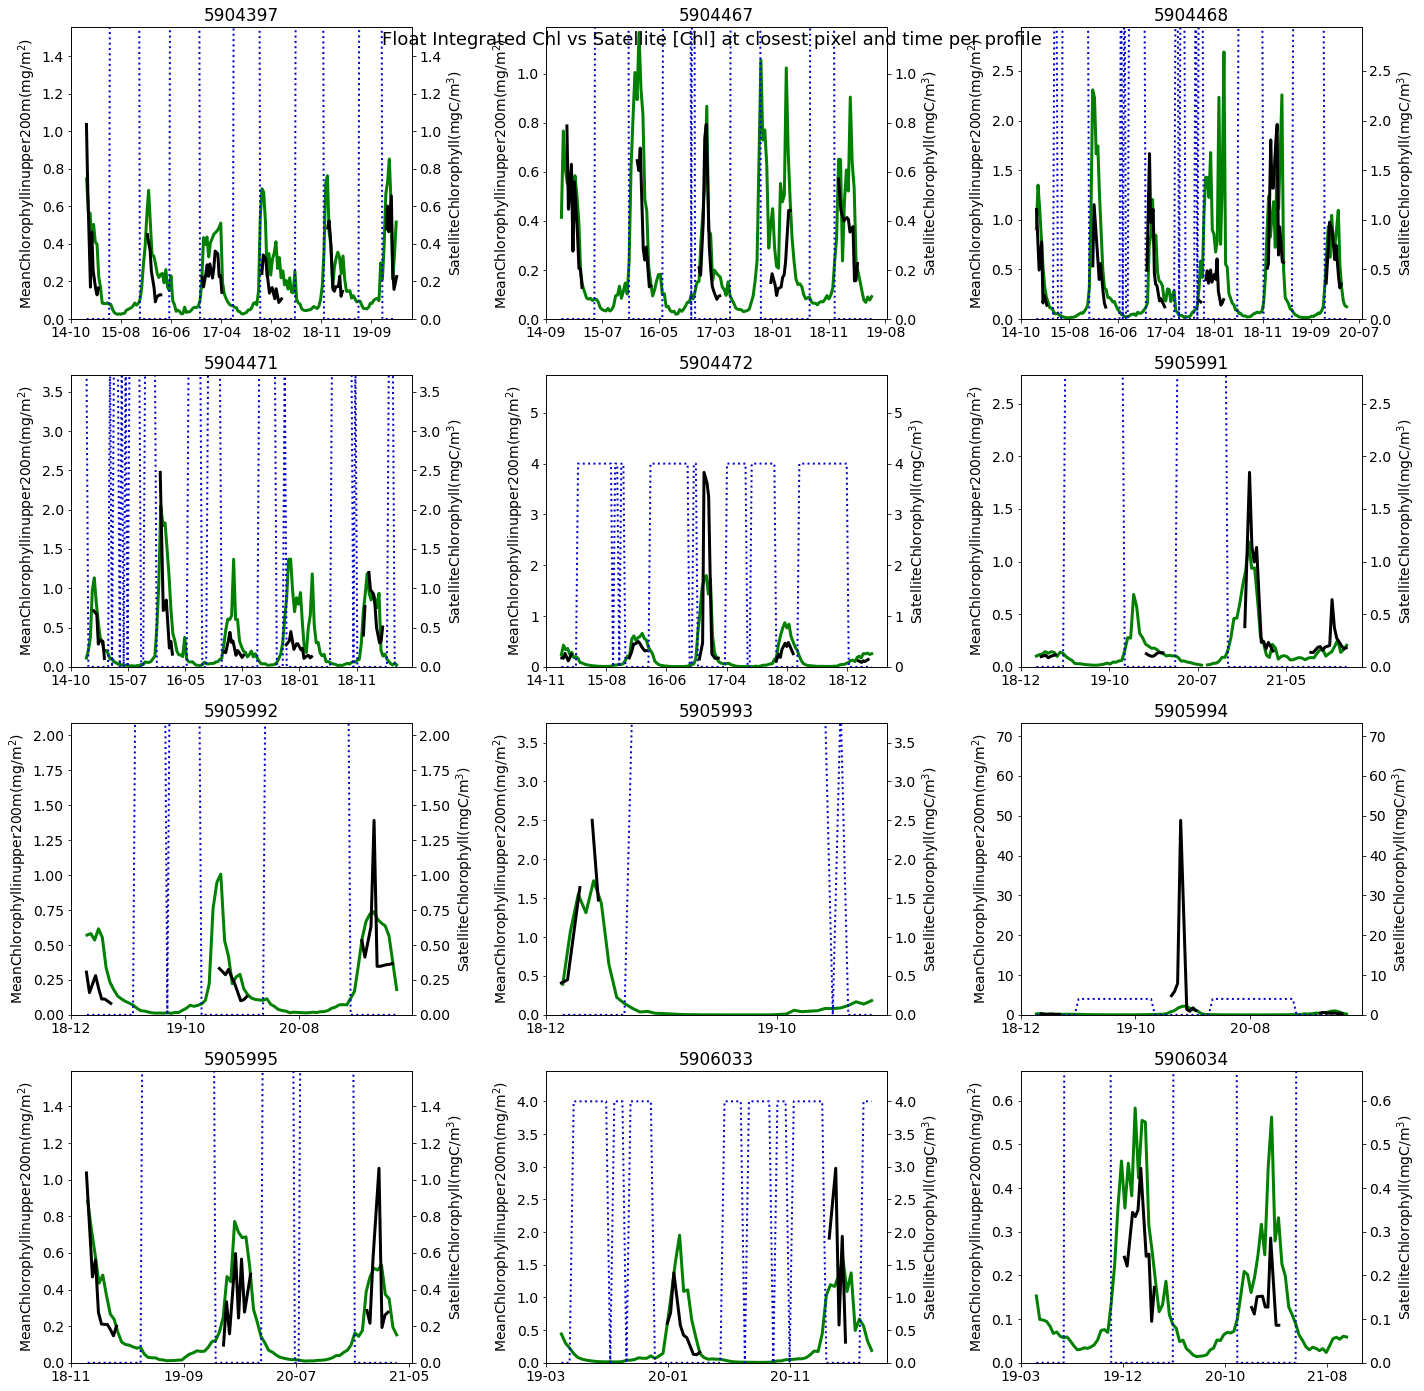

In [48]:

#plt.figure(figsize=(40, 30))
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Float Integrated Chl vs Satellite [Chl] at closest pixel and time per profile", fontsize=18, y=0.95)

# loop through the length of tickers and keep track of index
for n, float_ in enumerate(float_ID):
    # add a new subplot iteratively
    ax = plt.subplot(np.int(float_ID.size/3),3,n+1)#(1,1,n+1)#(3, 4, n + 1)
    #ax = plt.subplot(1,2,n+1)#(1,1,n+1)#(3, 4, n + 1)
    plt.title(float_)
    #print(n,float_)
    #ID=float_ID[f_ix]
    #chl=AllFloats[float_]['chl_intr200']
    chl=AllFloats[float_]['dMean_Chl']
    date=AllFloats[float_]['dates_dt']
    plt.plot(date,chl,c='green',lw=3)
    #plt.plot(date,np.max(chl)*AllFloats[float_]['underice_yesno'],c='mediumblue',ls=':',lw=3)
    plt.plot(date,4*AllFloats[float_]['underice_yesno'],c='mediumblue',ls=':',lw=2)
    #ax.set_ylim(0,4)
    #ax.set_ylabel('$\mathregular {Depth Integrated Chlorophyll (mg/m^2)}$')
    ax.set_ylabel('$\mathregular {Mean Chlorophyll in upper 200m (mg/m^2)}$')
    
    ax1=ax.twinx()
    ax1.plot(AllFloats[float_]['sat_date'],AllFloats[float_]['Chl_atprofiles'], c='black',linewidth=3)
    ax1.set_ylabel('$\mathregular {Satellite Chlorophyll (mgC/m^3)}$')
    
    start, end = ax.get_xlim()
    #print(start,end)
    ax.xaxis.set_ticks(np.arange(start, end, 300))
    #ax1.set_ylim(0,4)
    
    # Define date format
    date_form=DateFormatter("%y-%m")
    ax.xaxis.set_major_formatter(date_form)
    
    ax.set_ylim(0,np.nanmax(AllFloats[float_]['Chl_atprofiles'])*1.5)
    ax1.set_ylim(0,np.nanmax(AllFloats[float_]['Chl_atprofiles'])*1.5)
    
plt.tight_layout()#pad=5, w_pad=2, h_pad=2
#plt.rcParams.update({'font.size': 14})
plt.rc('font', size=14)
#plt.rc('font', size=15)
plt.savefig("2floatChl_SatelliteChl.eps",
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = True,
            facecolor ="w",
            edgecolor ='w',
            orientation ='landscape')

In [51]:
float_ID.size

3

### What fraction of profiles don't have corresponding satellite values 
(for whatever reason - ice coverage, pos cloud coverage, not enough light for satellite) 

(note: float location estimated when it is under ice, but can also expect that satellite doesn't have values for where float probably is because it will also be seeing ice)

In [19]:
#### get index for profiles that don't have satellite coverage
    ### FROM: AllFloats[FLOAT.gr["WMO_code"]]['satnan']
#
for n, float_ in enumerate(float_ID):
    startyear=AllFloats[float_]["dates_dt"][0].year
    endyear=AllFloats[float_]["dates_dt"][-1].year
    AllFloats[float_]["Av_prop_numprofs_satnan"]=[]
    temp=[]
    #print(startyear, '-', endyear)
    for yix in range(startyear,endyear+1,1):
        #AllFloats[float_][yix]["aust_ix"]=[] # made earlier
        AllFloats[float_][yix]["satnan_ix"]=[]
        AllFloats[float_][yix]["sat_ix"]=[]
        for i in range(len(AllFloats[float_]["dates_dt"])):
            decy = pyasl.decimalYear(AllFloats[float_]["dates_dt"][i]) 
            smol=decy>=(yix-0.5)
            tol=decy<(yix+0.5)
            satnan=AllFloats[float_]['satnan'][i]>0
            sat=AllFloats[float_]['satnan'][i]==0
            if smol==tol==satnan:
                AllFloats[float_][yix]["satnan_ix"]=np.append(AllFloats[float_][yix]["satnan_ix"],i)
            if smol==tol==sat:
                AllFloats[float_][yix]["sat_ix"]=np.append(AllFloats[float_][yix]["sat_ix"],i)
        AllFloats[float_][yix]["satnan_ix"]=np.int_(AllFloats[float_][yix]["satnan_ix"])
        AllFloats[float_][yix]["sat_ix"]=np.int_(AllFloats[float_][yix]["sat_ix"])
        
        #### Total when no corresponding sat data
        AllFloats[float_][yix]["Tot_satnan_chl"]=np.round(np.nansum(AllFloats[float_]['chl_intr200'][AllFloats[float_][yix]["satnan_ix"]]),6)
        #### Total when sat data matches up
        AllFloats[float_][yix]["Tot_sat_chl"]=np.round(np.nansum(AllFloats[float_]['chl_intr200'][AllFloats[float_][yix]["sat_ix"]]),6)
        #### proportion for austral year
        AllFloats[float_][yix]["Prop_satnan"]=np.round(AllFloats[float_][yix]["Tot_satnan_chl"]/AllFloats[float_][yix]["Tot_aus_chl"],6)
        AllFloats[float_][yix]["Prop_sat"]=np.round(AllFloats[float_][yix]["Tot_sat_chl"]/AllFloats[float_][yix]["Tot_aus_chl"],6)
        
        #### Number of profiles in austral year
        AllFloats[float_][yix]["numprofs_tot"]=len(AllFloats[float_][yix]["aust_ix"])
        #### Number of profiles without corresponding sat values
        AllFloats[float_][yix]["numprofs_satnan"]=len(AllFloats[float_][yix]["satnan_ix"])
        #### Number of profiles with corresponding sat values
        AllFloats[float_][yix]["numprofs_sat"]=len(AllFloats[float_][yix]["sat_ix"])
        
        if AllFloats[float_][yix]["numprofs_tot"]>0:
            AllFloats[float_][yix]["Prop_numprofs_satnan"]=AllFloats[float_][yix]["numprofs_satnan"]/AllFloats[float_][yix]["numprofs_tot"]
        else:
            continue
        temp=np.append(temp,AllFloats[float_][yix]["Prop_numprofs_satnan"])
        print('Proportion of Integrated Chl observed on no sat profiles: Float',float_,yix,'=',np.round(AllFloats[float_][yix]["Prop_satnan"],3))
    AllFloats[float_]["Av_prop_numprofs_satnan"]=np.round(np.nanmean(temp),6)
    print('Float',float_,'Av proportion of number of profiles where satellite values were NaN:',AllFloats[float_]["Av_prop_numprofs_satnan"],'+/-',np.round(np.std(temp),6))
    
    
          

Proportion of Integrated Chl observed on no sat profiles: Float 5904397 2015 = nan
Proportion of Integrated Chl observed on no sat profiles: Float 5904397 2016 = 0.338
Proportion of Integrated Chl observed on no sat profiles: Float 5904397 2017 = 0.131
Proportion of Integrated Chl observed on no sat profiles: Float 5904397 2018 = 0.347
Proportion of Integrated Chl observed on no sat profiles: Float 5904397 2019 = 0.353
Proportion of Integrated Chl observed on no sat profiles: Float 5904397 2020 = nan
Float 5904397 Av proportion of number of profiles where satellite values were NaN: 0.654302 +/- 0.078484
Proportion of Integrated Chl observed on no sat profiles: Float 5904467 2015 = nan
Proportion of Integrated Chl observed on no sat profiles: Float 5904467 2016 = 0.454
Proportion of Integrated Chl observed on no sat profiles: Float 5904467 2017 = 0.185
Proportion of Integrated Chl observed on no sat profiles: Float 5904467 2018 = 0.434
Proportion of Integrated Chl observed on no sat pro

In [20]:
floatav=[]
for n, float_ in enumerate(float_ID):
    startyear=AllFloats[float_]["dates_dt"][0].year
    endyear=AllFloats[float_]["dates_dt"][-1].year
    #print(startyear, '-', endyear)
    temp=[]
    
    for yix in range(startyear,endyear+1,1):
        temp=np.append(temp,AllFloats[float_][yix]["Prop_satnan"])
    floatav=np.append(floatav,np.nanmean(temp))
#print(floatav)
floatallav=np.nanmean(floatav)
floatallstd=np.nanstd(floatav)
print('Av chl missed where satellite values were NaN:',np.round(floatallav,3),'+/-',np.round(floatallstd,3))

Av chl missed where satellite values were NaN: 0.241 +/- 0.139


In [21]:
floatav=[]
for n, float_ in enumerate(float_ID):
    startyear=AllFloats[float_]["dates_dt"][0].year
    endyear=AllFloats[float_]["dates_dt"][-1].year
    #print(startyear, '-', endyear)
    temp=[]
    
    for yix in range(startyear,endyear+1,1):
        temp=np.append(temp,AllFloats[float_][yix]["Prop_underice"])
    floatav=np.append(floatav,np.nanmean(temp))
#print(floatav)
floatallav=np.nanmean(floatav)
floatallstd=np.nanstd(floatav)
print('Av chl missed when there is ice:',np.round(floatallav,3),'+/-',np.round(floatallstd,3))

Av chl missed when there is ice: 0.046 +/- 0.019


In [22]:
floatav=[]
for n, float_ in enumerate(float_ID):
    startyear=AllFloats[float_]["dates_dt"][0].year
    endyear=AllFloats[float_]["dates_dt"][-1].year
    #print(startyear, '-', endyear)
    temp=[]
    
    for yix in range(startyear,endyear+1,1):
        temp=np.append(temp,AllFloats[float_][yix]["Prop_nosat"])
    floatav=np.append(floatav,np.nanmean(temp))
#print(floatav)
floatallav=np.nanmean(floatav)
floatallstd=np.nanstd(floatav)
print('Av chl missed where there is no light :',np.round(floatallav,3),'+/-',np.round(floatallstd,3))



Av chl missed where there is no light : 0.132 +/- 0.072


## Match-up

### Get info from a single profile

In [7]:
print(FLOAT.gr["date_dt"][0])
print(FLOAT.gr["Lat"][0])
print(FLOAT.gr["Lon"][0])


2014-12-21 12:45:59.999996
-10000000000.0
-10000000000.0


### Select satellite pixel and get NPP value

In [8]:
float_date = FLOAT.gr["date_dt"][0]
# get all differences with date as values 
cloz_dict = { 
  abs(float_date.timestamp() - date.timestamp()) : date 
  for date in datezz}
# extracting minimum key using min()
sat_date = cloz_dict[min(cloz_dict.keys())]
# printing result
print("Nearest date from float date : " + str(sat_date))

date_ix=np.where(datezz==sat_date)
date_sel=chl_satellite['date'][date_ix]

chl_satellite['npp'].sel(date=date_sel,lat=FLOAT.gr["Lat"][0],lon=FLOAT.gr["Lon"][0],method='nearest').values

Nearest date from float date : 2014-12-22 23:59:59.500003


C:\anaconda\anaconda3\envs\argo_ncp\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
C:\anaconda\anaconda3\envs\argo_ncp\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


array([-9999.])

### Get info from profiles - all

## Plot some maps?
load in the nc file with nans here!

In [49]:
rootdir = '../data/interim/'
satfiles = sorted(glob.glob(rootdir+"/chl*nans.nc")) #nans
print(satfiles)

chl_satellite=xr.open_dataset(satfiles[0])
#display(chl_satellite)


['../data/interim\\chl_2014onwards_nans.nc']


In [50]:
rootdir = '../data/processed/'
satfiles = sorted(glob.glob(rootdir+"/*.nc")) #nans
print(satfiles)
nppAn_satellite=xr.open_dataset(satfiles[0])

OObox=pd.read_csv('../data/processed/OpenOceanMinusWAPJan22.csv',header=None).values
SRbox=pd.read_csv('../data/processed/ShelfMinusWAPJan22.csv',header=None).values
APbox=pd.read_csv('../data/processed/WAPJan22.csv',header=None).values

['../data/processed\\meanAnnppALL.nc']


In [51]:
display(nppAn_satellite)
nppAn_satellite.npp.shape
nppAn_satellite.lon.shape

<xarray.Dataset>
Dimensions:  (lon: 1380, lat: 1080)
Coordinates:
  * lon      (lon) float64 -74.96 -74.88 -74.79 -74.71 ... 39.79 39.87 39.96
  * lat      (lat) float64 -0.04167 -0.125 -0.2083 ... -89.79 -89.87 -89.96
Data variables:
    npp      (lon, lat) float64 ...

(1380,)

Text(0.5, 1.0, '2014-01-04 23:59:59.500003')

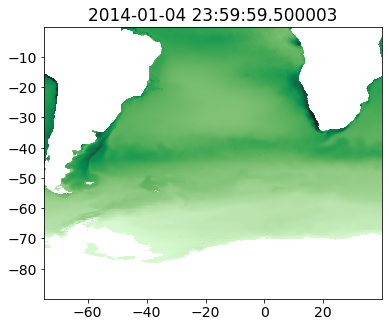

In [52]:
fig = plt.figure(figsize = (10,14))
ax0 = fig.add_axes([0.17,0.35,0.47,0.27])
slice=0
#cfT=ax0.contourf(chl_satellite.lat,chl_satellite.lon,chl_satellite.npp[20],10, cmap = cmocean.cm.algae)
#cfT=ax0.contourf(chl_satellite.lon,chl_satellite.lat,chl_satellite.chl[slice].T,300, cmap = cmocean.cm.algae)
cfT=ax0.contourf(nppAn_satellite.lon,nppAn_satellite.lat,nppAn_satellite.npp.T,300, cmap = cmocean.cm.algae)
plt.title(datezz[slice])

In [53]:
chl_satellite.chl[0,0,0].values
chl_satellite.chl.size

## make mean npp across timeseries
#ignoring nans
npp_mean=chl_satellite.chl.mean(dim="date",skipna=True)

(-80.0, 0.0)

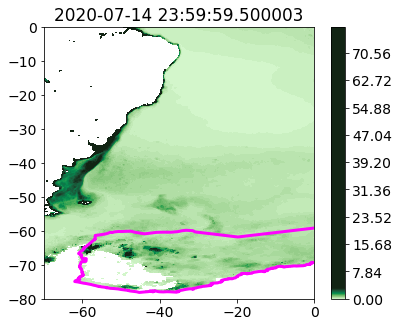

In [54]:
fig = plt.figure(figsize = (10,14))
ax0 = fig.add_axes([0.17,0.35,0.47,0.27])
slice=300
#cfT=ax0.contourf(chl_satellite.lat,chl_satellite.lon,chl_satellite.npp[20],10, cmap = cmocean.cm.algae)
cfT=ax0.contourf(chl_satellite.lon,chl_satellite.lat,npp_mean.T,1000, cmap = cmocean.cm.algae)
#cbar = fig.colorbar(contourf_)
cfT.set_clim( 0,3 )
cbar = fig.colorbar(cfT)

plt.title(datezz[slice])
ANDbox=pd.read_csv('../data/processed/ANDREXbox.csv',header=None).values
box = ax0.plot(ANDbox[:,0],ANDbox[:,1],color='magenta', linestyle='solid',linewidth=3)

ax0.set_xlim(-70, 0)
ax0.set_ylim(-80, 0)

In [55]:
float_ID

array(['5904397', '5904467', '5904468', '5904471', '5904472', '5905991',
       '5905992', '5905993', '5905994', '5905995', '5906033', '5906034'],
      dtype='<U32')

In [57]:
## work out how to plot trajectory with color for data overlaid
from argopy import IndexFetcher as ArgoIndexFetcher
from mpl_toolkits.axes_grid1 import make_axes_locatable

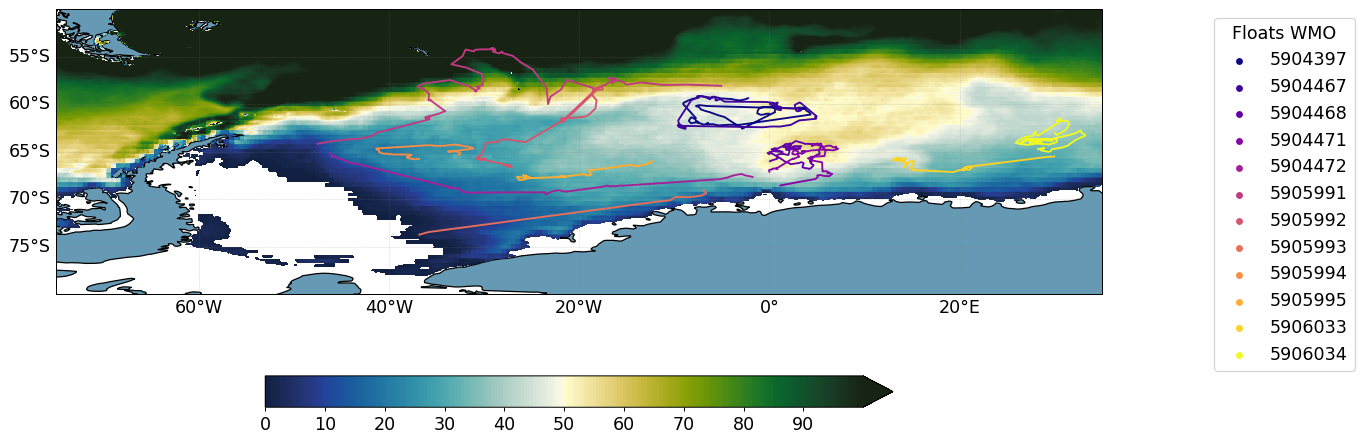

In [70]:
#fig, ax = plt.subplots(figsize = (20, 8))
#for n, float_ in enumerate(float_ID[0:1]):
fid=float_ID[:].tolist()
idx = ArgoIndexFetcher().float(float_ID).load() #float(fid)
fig, ax = idx.plot('trajectory', palette='plasma',figsize=(15, 8),linewidth=3)
levels = np.linspace(0.0, 100.0, 200)
cont=ax.contourf(nppAn_satellite.lon,nppAn_satellite.lat,nppAn_satellite.npp.T,levels=levels, cmap = cmocean.cm.delta,extend='max')
cont.set_clim(vmin=0, vmax=100)
cbar = fig.colorbar(cont,ticks=[0, 10,20,30,40,50,60,70,80,90],shrink=0.6,location="bottom")
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
#cbar = fig.colorbar(cont,cax=cax)

#box1 = ax.plot(OObox[:,0],OObox[:,1],color='rosybrown', linestyle='solid',linewidth=3)
#box2 = ax.plot(SRbox[:,0],SRbox[:,1],color='darkkhaki', linestyle='solid',linewidth=3)
ax.set_xlim(-75,35)
ax.set_ylim(-80, -50)
#ax.title('WG float trajectories over timeseries mean chl concentration')

#savefig(FloatTrajChl, dpi=300, format='pdf', transparent=True)
fig.savefig("Map_floatsv.jpg",
            bbox_inches ="tight",
            pad_inches = 1,
            #transparent = True,
            #facecolor ="w",
            #edgecolor ='w',
            orientation ='landscape')

#plt.scatter(x, y, c=t)

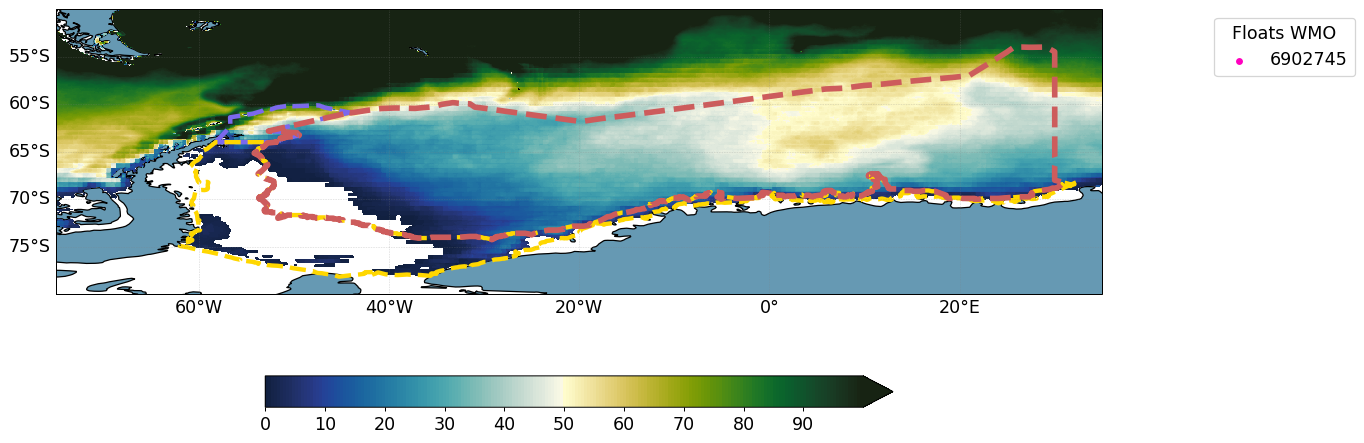

In [79]:
#fig, ax = plt.subplots(figsize = (20, 8))
#for n, float_ in enumerate(float_ID[0:1]):
fid=float_ID[:].tolist()
idx = ArgoIndexFetcher().float(6902745).load() #float(fid)
fig, ax = idx.plot('trajectory', palette='gist_rainbow_r',figsize=(15, 8),linewidth=3)
levels = np.linspace(0.0, 100.0, 200)
cont=ax.contourf(nppAn_satellite.lon,nppAn_satellite.lat,nppAn_satellite.npp.T,levels=levels, cmap = cmocean.cm.delta,extend='max')
cont.set_clim(vmin=0, vmax=100)
cbar = fig.colorbar(cont,ticks=[0, 10,20,30,40,50,60,70,80,90],shrink=0.6,location="bottom")
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
#cbar = fig.colorbar(cont,cax=cax)


box3 = ax.plot(APbox[:,0],APbox[:,1],color='mediumslateblue', linestyle='dashed',linewidth=3.6)
box2 = ax.plot(SRbox[:,0],SRbox[:,1],color='gold', linestyle='dashed',linewidth=3.5)
box1 = ax.plot(OObox[:,0],OObox[:,1],color='indianred', linestyle='dashed',linewidth=4.5)

ax.set_xlim(-75,35)
ax.set_ylim(-80, -50)
#ax.title('WG float trajectories over timeseries mean chl concentration')

#savefig(FloatTrajChl, dpi=300, format='pdf', transparent=True)
fig.savefig("Map_regionsg.jpg",
            bbox_inches ="tight",
            pad_inches = 1,
            #transparent = True,
            #facecolor ="w",
            #edgecolor ='w',
            orientation ='landscape')

#plt.scatter(x, y, c=t)

In [120]:
OObox.shape

(2871, 2)

fig.colorbar?

## Float sea ice and chl preliminary analysis
### Single float with no polynyas

In [23]:
# test get day of year
day_of_year = AllFloats['5904397']['dates_dt'][0].timetuple().tm_yday
print(AllFloats['5904397']['dates_dt'][0],'DoY:',day_of_year)

2015-01-22 05:14:00.000004 DoY: 22


In [24]:
for n, float_ in enumerate(float_ID):
    AllFloats[float_]['DoY']=[]
    for x,dt in enumerate(AllFloats[float_]['dates_dt']):
        #print(dt.timetuple().tm_yday)
        AllFloats[float_]['DoY']=np.append(AllFloats[float_]['DoY'],dt.timetuple().tm_yday)  

In [25]:
print('Float keys:', AllFloats['5904397'].keys())
print('~~~~~~~~~~~~')
print('Annual keys:', AllFloats['5904397'][2015].keys())


Float keys: dict_keys(['dates_dt', 'lon', 'lat', 'chl_intr200', 'chl_intr_dMLD', 'dint_chla', 'chl_intrWC', 'dMean_Chl', 'dMax_Chl', 'surf_Chl', 2015, 'underice_yesno', 'InterPos', 'underice_yesno_IP', 2016, 2017, 2018, 2019, 2020, 'no_sat_yesno', 'Chl_atprofiles', 'satnan', 'sat_date', 'Av_prop_numprofs_satnan', 'DoY'])
~~~~~~~~~~~~
Annual keys: dict_keys(['aust_ix', 'underice_ix', 'icefree_ix', 'Tot_aus_chl', 'Tot_underice_chl', 'Tot_icefree_chl', 'Prop_underice', 'Prop_icefree', 'no_sat', 'Tot_nosat_chl', 'Prop_nosat', 'satnan_ix', 'sat_ix', 'Tot_satnan_chl', 'Tot_sat_chl', 'Prop_satnan', 'Prop_sat', 'numprofs_tot', 'numprofs_satnan', 'numprofs_sat', 'Prop_numprofs_satnan'])


In [26]:
print(AllFloats['5904397']['underice_yesno'])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [27]:
print(AllFloats['5904397'][2016]['aust_ix'])

[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45 46 47 48 49 50 51]


In [28]:
icechangeix=np.full(len(AllFloats['5904397']['underice_yesno']),np.nan)
for ix,dt in enumerate(AllFloats['5904397']['underice_yesno']):
    #print(ix-1)
    if ix==0:
        continue
    else:
        if AllFloats['5904397']['underice_yesno'][ix]-AllFloats['5904397']['underice_yesno'][ix-1]==1:
            icechangeix[ix]=2 #2 where ice season (IS) starts
        elif AllFloats['5904397']['underice_yesno'][ix]-AllFloats['5904397']['underice_yesno'][ix-1]==(-1):
            icechangeix[ix]=1 #1 where growing season (GS) starts
        elif AllFloats['5904397']['underice_yesno'][ix]-AllFloats['5904397']['underice_yesno'][ix-1]==0:
            icechangeix[ix]=0 #0 the rest of the time
print(icechangeix)

GSstart=np.where(icechangeix==1)
DoY_GSstart=AllFloats['5904397']['DoY'][GSstart]
print(DoY_GSstart)
ISstart=np.where(icechangeix==2)
DoY_ISstart=AllFloats['5904397']['DoY'][ISstart]
print(DoY_ISstart)

IS_length=DoY_GSstart-DoY_ISstart
print(IS_length)
tot_aus_chl_=[]
for yix,year in enumerate(range(2016,2020+1)):
    tot_aus_chl_=np.append(tot_aus_chl_,AllFloats['5904397'][year]['Tot_aus_chl'])
print(tot_aus_chl_)



[nan  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.]
[341. 336. 331. 347. 332.]
[167. 162. 177. 183. 199.]
[174. 174. 154. 164. 133.]
[2283.458125 2770.167565 2644.660631 2571.8784           nan]


In [29]:
print(AllFloats['5904397'][2020]['aust_ix'])

[158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180]


In [30]:
# correlations https://www.statology.org/correlation-in-python/
d = {'GSstartDoY': DoY_GSstart[0:4], 'ISlength': IS_length[0:4], 'Aus_chl': tot_aus_chl_[0:4], 'Year': range(2016,2020),'Polynya':[0,0,0,0]}
Float4397 = pd.DataFrame(data=d)
Float4397
#Float4397['ISlength'].corr(Float4397['Aus_chl'])
#Float4397.corr

,GSstartDoY,ISlength,Aus_chl,Year,Polynya
0,341.0,174.0,2283.458125,2016,0
1,336.0,174.0,2770.167565,2017,0
2,331.0,154.0,2644.660631,2018,0
3,347.0,164.0,2571.878400,2019,0


In [31]:
Float4397.corr()

,GSstartDoY,ISlength,Aus_chl,Year,Polynya
GSstartDoY,1.000000,0.368508,-0.414695,0.245021,NaN
ISlength,0.368508,1.000000,-0.267566,-0.674200,NaN
Aus_chl,-0.414695,-0.267566,1.000000,0.462840,NaN
Year,0.245021,-0.674200,0.462840,1.000000,NaN
Polynya,NaN,NaN,NaN,NaN,NaN


In [32]:
from scipy.stats.stats import pearsonr

pearsonr(Float4397['ISlength'], Float4397['Year']) # corr coef,p-value


(-0.674199862463242, 0.32580013753675796)

### Single float with polynyas

In [33]:
print('Float keys:', AllFloats['5904468'].keys())
print('~~~~~~~~~~~~')
print('Annual keys:', AllFloats['5904468'][2015].keys())


Float keys: dict_keys(['dates_dt', 'lon', 'lat', 'chl_intr200', 'chl_intr_dMLD', 'dint_chla', 'chl_intrWC', 'dMean_Chl', 'dMax_Chl', 'surf_Chl', 2015, 'underice_yesno', 'InterPos', 'underice_yesno_IP', 2016, 2017, 2018, 2019, 2020, 'no_sat_yesno', 'Chl_atprofiles', 'satnan', 'sat_date', 'Av_prop_numprofs_satnan', 'DoY'])
~~~~~~~~~~~~
Annual keys: dict_keys(['aust_ix', 'underice_ix', 'icefree_ix', 'Tot_aus_chl', 'Tot_underice_chl', 'Tot_icefree_chl', 'Prop_underice', 'Prop_icefree', 'no_sat', 'Tot_nosat_chl', 'Prop_nosat', 'satnan_ix', 'sat_ix', 'Tot_satnan_chl', 'Tot_sat_chl', 'Prop_satnan', 'Prop_sat', 'numprofs_tot', 'numprofs_satnan', 'numprofs_sat', 'Prop_numprofs_satnan'])


In [34]:
print(AllFloats['5904468']['underice_yesno'])
for n,dix in enumerate([ 32,  66, 101, 137, 174]):
    print(AllFloats['5904468']['dates_dt'][dix])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2015-12-14 13:24:00.000001
2016-11-29 09:48:59.999996
2017-11-24 19:16:00
2018-11-29 19:50:59.999995
2019-12-15 02:42:00.000004


In [35]:
print(AllFloats['5904468'][2015]['aust_ix'])
print(len(AllFloats['5904468']['lat']))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
188


In [36]:
icechangeix=np.full(len(AllFloats['5904468']['underice_yesno']),np.nan)
for ix,dt in enumerate(AllFloats['5904468']['underice_yesno']):
    #print(ix-1)
    if ix==0:
        continue
    elif ix==188:
        continue
    else:
        if AllFloats['5904468']['underice_yesno'][ix]-AllFloats['5904468']['underice_yesno'][ix-1]==1:
            icechangeix[ix]=2 #2 where ice season (IS) starts
        
            if np.any(AllFloats['5904468']['underice_yesno'][range(ix-9,ix)]):
                #print(ix)
                icechangeix[ix]=0 #where there is a polynya
            else:
                icechangeix[ix]=2 #2 where ice season (IS) starts
        
        elif AllFloats['5904468']['underice_yesno'][ix]-AllFloats['5904468']['underice_yesno'][ix-1]==(-1):
            if np.any(AllFloats['5904468']['underice_yesno'][range(ix,ix+9)]):
                #print(ix)
                icechangeix[ix]=3 #where there is a polynya
            else:
                icechangeix[ix]=1 #1 where growing season (GS) starts
        elif AllFloats['5904468']['underice_yesno'][ix]-AllFloats['5904468']['underice_yesno'][ix-1]==0:
            icechangeix[ix]=0 #0 the rest of the time
print('5904468 : ',icechangeix)

5904468 :  [nan  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  3.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  3.  0.
  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  3.  0.  0.  0.
  3.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]


In [37]:
GSstart=np.where(icechangeix==1)
print(GSstart)
DoY_GSstart=AllFloats['5904468']['DoY'][GSstart]
print('DoY of first ice free profile:',DoY_GSstart)
ISstart=np.where(icechangeix==2)
DoY_ISstart=AllFloats['5904468']['DoY'][ISstart]
print('DoY of first under-ice profile',DoY_ISstart)

IS_length=DoY_GSstart-DoY_ISstart
print(IS_length)
tot_aus_chl_=[]
for yix,year in enumerate(range(2016,2020+1)):
    tot_aus_chl_=np.append(tot_aus_chl_,AllFloats['5904468'][year]['Tot_aus_chl'])
print(tot_aus_chl_)

(array([ 32,  66, 101, 137, 174], dtype=int64),)
DoY of first ice free profile: [348. 334. 328. 333. 349.]
DoY of first under-ice profile [133. 180. 153. 180. 154.]
[215. 154. 175. 153. 195.]
[7054.569396 4654.585855 9498.982539 9368.606315         nan]


In [38]:
print(AllFloats['5904468'][2020]['aust_ix'])

[158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187]


In [39]:
#if polynya...
polynya_present=np.where(icechangeix==3)
poly_present=list(polynya_present)
print(len(polynya_present[0]))
print(poly_present[0][0])
DoY_poly=AllFloats['5904468']['DoY'][polynya_present]
#print(DoY_poly)

6
13


In [40]:
#polynyadates=[]
#print(AllFloats['5904468']['dates_dt'][0].year)
polyYEAR=[]
for dix in range(0,len(polynya_present[0])):
    polyIX=polynya_present[0][dix]
    polyYEAR=np.append(polyYEAR,AllFloats['5904468']['dates_dt'][polyIX].year)
polynyadates=np.unique(polyYEAR)
print(polynyadates)
poly_AUSyears=polynyadates+1
print(poly_AUSyears)

[2015. 2016. 2017.]
[2016. 2017. 2018.]


In [41]:
# correlations https://www.statology.org/correlation-in-python/
d2 = {'GSstartDoY': DoY_GSstart[0:4], 'ISlength': IS_length[0:4], 'Aus_chl': tot_aus_chl_[0:4], 'Year': range(2016,2020),'Polynya':[1,1,1,0]}
Float4468 = pd.DataFrame(data=d2)
Float4468
#Float4397['ISlength'].corr(Float4397['Aus_chl'])
#Float4397.corr

,GSstartDoY,ISlength,Aus_chl,Year,Polynya
0,348.0,215.0,7054.569396,2016,1
1,334.0,154.0,4654.585855,2017,1
2,328.0,175.0,9498.982539,2018,1
3,333.0,153.0,9368.606315,2019,0


In [42]:
Float4468.corr()

,GSstartDoY,ISlength,Aus_chl,Year,Polynya
GSstartDoY,1.000000,0.786929,-0.358553,-0.767547,0.213723
ISlength,0.786929,1.000000,0.006330,-0.734568,0.488530
Aus_chl,-0.358553,0.006330,1.000000,0.665167,-0.502543
Year,-0.767547,-0.734568,0.665167,1.000000,-0.774597
Polynya,0.213723,0.488530,-0.502543,-0.774597,1.000000


In [43]:
from scipy.stats.stats import pearsonr

pearsonr(Float4468['ISlength'], Float4468['Year']) # corr coef,p-value


(-0.7345677187474448, 0.26543228125255525)

In [44]:
TWOfloats=pd.concat([Float4397,Float4468])
TWOfloats

,GSstartDoY,ISlength,Aus_chl,Year,Polynya
0,341.0,174.0,2283.458125,2016,0
1,336.0,174.0,2770.167565,2017,0
2,331.0,154.0,2644.660631,2018,0
3,347.0,164.0,2571.878400,2019,0
0,348.0,215.0,7054.569396,2016,1
1,334.0,154.0,4654.585855,2017,1
2,328.0,175.0,9498.982539,2018,1
3,333.0,153.0,9368.606315,2019,0


In [45]:
TWOfloats.corr()

,GSstartDoY,ISlength,Aus_chl,Year,Polynya
GSstartDoY,1.000000,0.582772,-0.333499,-0.308424,-0.065604
ISlength,0.582772,1.000000,0.176739,-0.629325,0.444459
Aus_chl,-0.333499,0.176739,1.000000,0.241298,0.524103
Year,-0.308424,-0.629325,0.241298,1.000000,-0.346410
Polynya,-0.065604,0.444459,0.524103,-0.346410,1.000000


From these two floats (4397 and 4468):

* Day of first ice-free profile ('GS start') is correlated with the length of the ice season - longer ice season with later GS start
* IS length and GS start are both negatively correlated with year - earlier ice melt/floats out from ice and consequently(?) shorter IS length with time
* Total chl to 200m over austral year: 
    * Strongest correlation (0.52) seen with presence of polynyas/floats coming to surface during ice season
    * Next strongest is with day of first ice-free profile (-0.33) - more chl the earlier the GS start day


In [46]:
from scipy.stats import spearmanr
pearsonr(TWOfloats['GSstartDoY'], TWOfloats['ISlength']) # corr coef,p-value
spearmanr(TWOfloats['GSstartDoY'], TWOfloats['ISlength']) # corr coef,p-value


SpearmanrResult(correlation=0.3735210868517069, pvalue=0.36206259826316556)

<function matplotlib.pyplot.show(close=None, block=None)>

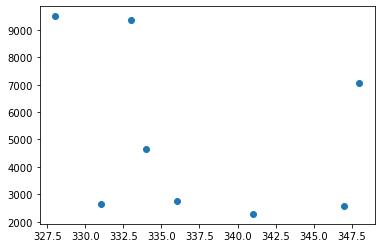

In [47]:
plt.scatter(TWOfloats.GSstartDoY,TWOfloats.Aus_chl)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

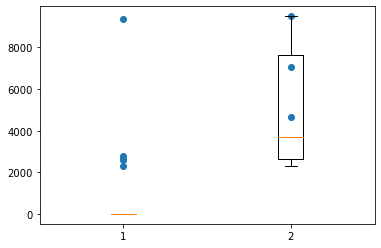

In [48]:
plt.boxplot([TWOfloats.Polynya,TWOfloats.Aus_chl])
plt.scatter((TWOfloats.Polynya+1),TWOfloats.Aus_chl)
plt.show

### ALL floats

In [82]:
for n, float_ in enumerate(float_ID):
    #print(float_)
    AllFloats[float_]['icechangeix']=np.full(len(AllFloats[float_]['underice_yesno']),np.nan)
    for ix,dt in enumerate(AllFloats[float_]['underice_yesno']):
        #print(ix-1)
        if ix==0:
            continue
        elif ix==188:
            continue
        else:
            if AllFloats[float_]['underice_yesno'][ix]-AllFloats[float_]['underice_yesno'][ix-1]==1:
                AllFloats[float_]['icechangeix'][ix]=2 #2 where ice season (IS) starts
            
                if np.any(AllFloats[float_]['underice_yesno'][range(ix-9,ix)]):
                    #print(ix)
                    AllFloats[float_]['icechangeix'][ix]=0 #where there is a polynya
                else:
                    AllFloats[float_]['icechangeix'][ix]=2 #2 where ice season (IS) starts
            
            elif AllFloats[float_]['underice_yesno'][ix]-AllFloats[float_]['underice_yesno'][ix-1]==(-1):
                if ix>=(len(AllFloats[float_]['underice_yesno'])-8):
                    
                    if (3<AllFloats[float_]['dates_dt'][ix].month<11) | (np.any(AllFloats[float_]['underice_yesno'][range(ix,len(AllFloats[float_]['underice_yesno']))])):
                    #if 3<AllFloats[float_]['dates_dt'][ix].month<11:
                        AllFloats[float_]['icechangeix'][ix]=3 #where there is a polynya
                    else:
                        AllFloats[float_]['icechangeix'][ix]=1 #1 where growing season (GS) starts
                        
                elif np.any(AllFloats[float_]['underice_yesno'][range(ix,ix+8)]):
                    #print(ix)
                    AllFloats[float_]['icechangeix'][ix]=3 #where there is a polynya
                else:
                    AllFloats[float_]['icechangeix'][ix]=1 #1 where growing season (GS) starts
            elif AllFloats[float_]['underice_yesno'][ix]-AllFloats[float_]['underice_yesno'][ix-1]==0:
                AllFloats[float_]['icechangeix'][ix]=0 #0 the rest of the time
    print(float_,':', AllFloats[float_]['icechangeix'])

5904397 : [nan  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.]
5904467 : [nan  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.
  0.  0.  0.  0.  0.  0. 

In [50]:
# still beta-ing ...
len(AllFloats['5904471']['underice_yesno'])

159

2019-04-30 23:25:00.000004
2019-04-30 23:25:00.000004
120


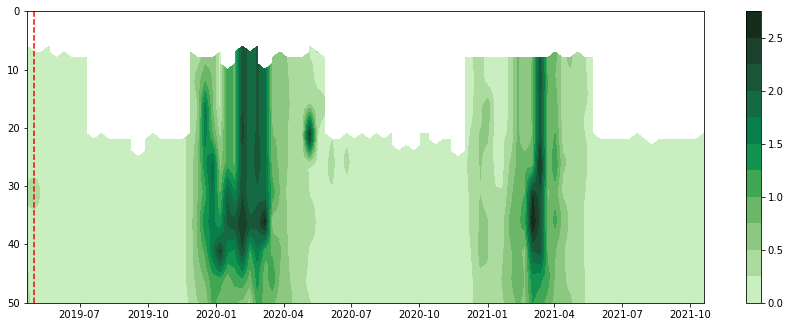

In [93]:
fig = plt.figure(figsize = (25,15))
ax0 = fig.add_axes([0.57,0.35,0.47,0.27])
#num=np.arange(1,234,1)
AllRaw['5906034']['FLOAT'].gr["WMO_code"]

cfT=ax0.contourf(AllRaw['5906034']['FLOAT'].gr["date_dt"],AllRaw['5906034']['FLOAT'].gr["depth"][0:320],AllRaw['5906034']['FLOAT'].gr["Chl_a"][0:320],10, cmap = cmocean.cm.algae)
ax0.set_ylim(0,50)
#ax0.set_xlim(AllRaw['5904471']['FLOAT'].gr["date_dt"][0],AllRaw['5904471']['FLOAT'].gr["date_dt"][10])
plt.gca().invert_yaxis()
cb = fig.colorbar(cfT)

#create line plot
#plt.plot(df.x, df.y)

#add vertical line at x=2
plt.axvline(x=AllRaw['5906034']['FLOAT'].gr["date_dt"][1], color='red', linestyle='--')
print(AllRaw['5906034']['FLOAT'].gr["date_dt"][1])
print(AllFloats['5906034']['dates_dt'][1])
print(AllFloats['5906034']['dates_dt'][1].timetuple().tm_yday)
#ax0.plot(FLOAT.gr["date_dt"],np.full(FLOAT.gr["date"].size,5)) #i=1
#ax0.plot(FLOAT.gr["date_dt"],np.full(FLOAT.gr["date"].size,10)) #i=2
#ax0.plot(FLOAT.gr["date_dt"],np.full(FLOAT.gr["date"].size,15)) #i=3

In [83]:
AllFloats['5904471']['underice_yesno']

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
       0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0.])

In [65]:
for n, float_ in enumerate(float_ID):
    AllFloats[float_]['DoY']=[]
    for x,dt in enumerate(AllFloats[float_]['dates_dt']):
        #print(dt.timetuple().tm_yday)
        AllFloats[float_]['DoY']=np.append(AllFloats[float_]['DoY'],dt.timetuple().tm_yday)  

In [92]:
for n, float_ in enumerate(float_ID):
    print(float_)
    AllFloats[float_]['ISstart']=np.where(AllFloats[float_]['icechangeix']==2)
    AllFloats[float_]['DoY_ISstart']=[]
    for iix,iis in enumerate(AllFloats[float_]['ISstart'][0]):
        AllFloats[float_]['DoY_ISstart']=np.append(AllFloats[float_]['DoY_ISstart'],AllFloats[float_]['DoY'][iis])
    print('DoY of first under-ice profile',AllFloats[float_]['DoY_ISstart'])
    
    AllFloats[float_]['GSstart']=np.where(AllFloats[float_]['icechangeix']==1)
    #print(AllFloats[float_]['GSstart'])
    AllFloats[float_]['DoY_GSstart']=[]
    for gix,gs in enumerate(AllFloats[float_]['GSstart'][0]):
        AllFloats[float_]['DoY_GSstart']=np.append(AllFloats[float_]['DoY_GSstart'],AllFloats[float_]['DoY'][gs])
    print('DoY of first ice free profile:',AllFloats[float_]['DoY_GSstart'])
    
    #beta-ing
    #if len(AllFloats[float_]['DoY_GSstart'])==len(AllFloats[float_]['DoY_ISstart']): # dont like that solution...
        
    #if np.any(AllFloats[float_]['DoY_GSstart']>300):
    #    AllFloats[float_]['IS_length']=AllFloats[float_]['DoY_GSstart']-AllFloats[float_]['DoY_ISstart']
    #else:
    #    AllFloats[float_]['IS_length']=365-AllFloats[float_]['DoY_ISstart']+AllFloats[float_]['DoY_GSstart']
    #print(AllFloats[float_]['IS_length'])
    

5904397
DoY of first under-ice profile [167. 162. 177. 183. 199.]
DoY of first ice free profile: [341. 336. 331. 347. 332.]
5904467
DoY of first under-ice profile [169. 164. 157. 214.]
DoY of first ice free profile: [342. 327. 310. 337.]
5904468
DoY of first under-ice profile [133. 180. 153. 180. 154.]
DoY of first ice free profile: [348. 334. 328. 333. 349.]
5904471
DoY of first under-ice profile [114. 162. 167. 184. 117.]
DoY of first ice free profile: [365. 360. 336. 311. 317.]
5904472
DoY of first under-ice profile [101.  97. 112. 107.]
DoY of first ice free profile: [337. 333. 358. 353.]
5905991
DoY of first under-ice profile [129. 144.]
DoY of first ice free profile: [328. 313.]
5905992
DoY of first under-ice profile [153. 129.]
DoY of first ice free profile: [323. 349.]
5905993
DoY of first under-ice profile [97.]
DoY of first ice free profile: [12.]
5905994
DoY of first under-ice profile [134. 120.]
DoY of first ice free profile: [334. 340.]
5905995
DoY of first under-ice profi

In [317]:
tot_aus_chl_=[]
    for yix,year in enumerate(range(2016,2020+1)):
        tot_aus_chl_=np.append(tot_aus_chl_,AllFloats['5904468'][year]['Tot_aus_chl'])
    print(tot_aus_chl_)

In [318]:
print(AllFloats['5904468'][2020]['aust_ix'])

[158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187]


In [319]:
#if polynya...
polynya_present=np.where(AllFloats[float_]['icechangeix']==3)
poly_present=list(polynya_present)
print(len(polynya_present[0]))
print(poly_present[0][0])
DoY_poly=AllFloats['5904468']['DoY'][polynya_present]
#print(DoY_poly)

6
13


In [320]:
#polynyadates=[]
#print(AllFloats['5904468']['dates_dt'][0].year)
polyYEAR=[]
for dix in range(0,len(polynya_present[0])):
    polyIX=polynya_present[0][dix]
    polyYEAR=np.append(polyYEAR,AllFloats['5904468']['dates_dt'][polyIX].year)
polynyadates=np.unique(polyYEAR)
print(polynyadates)
poly_AUSyears=polynyadates+1
print(poly_AUSyears)

[2015. 2016. 2017.]
[2016. 2017. 2018.]


In [321]:
# correlations https://www.statology.org/correlation-in-python/
d2 = {'GSstartDoY': DoY_GSstart[0:4], 'ISlength': IS_length[0:4], 'Aus_chl': tot_aus_chl_[0:4], 'Year': range(2016,2020),'Polynya':[1,1,1,0]}
Float4468 = pd.DataFrame(data=d2)
Float4468
#Float4397['ISlength'].corr(Float4397['Aus_chl'])
#Float4397.corr

,GSstartDoY,ISlength,Aus_chl,Year,Polynya
0,348.0,215.0,7054.569396,2016,1
1,334.0,154.0,4654.585855,2017,1
2,328.0,175.0,9498.982539,2018,1
3,333.0,153.0,9368.606315,2019,0


In [322]:
Float4468.corr()

,GSstartDoY,ISlength,Aus_chl,Year,Polynya
GSstartDoY,1.000000,0.786929,-0.358553,-0.767547,0.213723
ISlength,0.786929,1.000000,0.006330,-0.734568,0.488530
Aus_chl,-0.358553,0.006330,1.000000,0.665167,-0.502543
Year,-0.767547,-0.734568,0.665167,1.000000,-0.774597
Polynya,0.213723,0.488530,-0.502543,-0.774597,1.000000


In [323]:
from scipy.stats.stats import pearsonr

pearsonr(Float4468['ISlength'], Float4468['Year']) # corr coef,p-value


(-0.7345677187474448, 0.26543228125255525)

In [324]:
TWOfloats=pd.concat([Float4397,Float4468])
TWOfloats

,GSstartDoY,ISlength,Aus_chl,Year,Polynya
0,341.0,174.0,2283.458125,2016,0
1,336.0,174.0,2770.167565,2017,0
2,331.0,154.0,2644.660631,2018,0
3,347.0,164.0,2571.878400,2019,0
0,348.0,215.0,7054.569396,2016,1
1,334.0,154.0,4654.585855,2017,1
2,328.0,175.0,9498.982539,2018,1
3,333.0,153.0,9368.606315,2019,0


In [325]:
TWOfloats.corr()

,GSstartDoY,ISlength,Aus_chl,Year,Polynya
GSstartDoY,1.000000,0.582772,-0.333499,-0.308424,-0.065604
ISlength,0.582772,1.000000,0.176739,-0.629325,0.444459
Aus_chl,-0.333499,0.176739,1.000000,0.241298,0.524103
Year,-0.308424,-0.629325,0.241298,1.000000,-0.346410
Polynya,-0.065604,0.444459,0.524103,-0.346410,1.000000


From these two floats (4397 and 4468):

* Day of first ice-free profile ('GS start') is correlated with the length of the ice season - longer ice season with later GS start
* IS length and GS start are both negatively correlated with year - earlier ice melt/floats out from ice and consequently(?) shorter IS length with time
* Total chl to 200m over austral year: 
    * Strongest correlation (0.52) seen with presence of polynyas/floats coming to surface during ice season
    * Next strongest is with day of first ice-free profile (-0.33) - more chl the earlier the GS start day


In [326]:
from scipy.stats import spearmanr
pearsonr(TWOfloats['GSstartDoY'], TWOfloats['ISlength']) # corr coef,p-value
spearmanr(TWOfloats['GSstartDoY'], TWOfloats['ISlength']) # corr coef,p-value


SpearmanrResult(correlation=0.3735210868517069, pvalue=0.36206259826316556)

<function matplotlib.pyplot.show(close=None, block=None)>

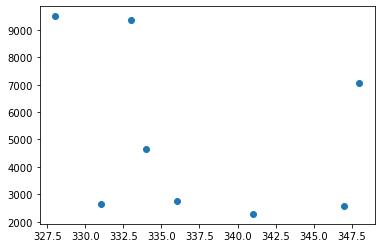

In [327]:
plt.scatter(TWOfloats.GSstartDoY,TWOfloats.Aus_chl)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

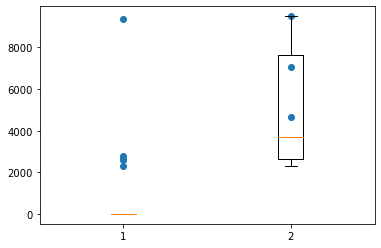

In [333]:
plt.boxplot([TWOfloats.Polynya,TWOfloats.Aus_chl])
plt.scatter((TWOfloats.Polynya+1),TWOfloats.Aus_chl)
plt.show